In [256]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
#Prepocesamiento y normalizacion de datos
from sklearn.preprocessing import StandardScaler
# divicion de los datos en train test
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
# Analisis de componentes principales
from sklearn.decomposition import IncrementalPCA
# EStimadores
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
#Modelos Logisticos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
# Medicion de efectividad de modelo
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Optimizacion Parametrica
from sklearn.model_selection import RandomizedSearchCV
import joblib 

import warnings
warnings.filterwarnings("ignore")

# Seleccion de Variables

In [257]:
data = pd.read_csv("dataML.csv")
data = data.drop(columns = "Unnamed: 0" ) 
dataset = data.copy(deep = True)

dataset = dataset.sample(frac=1)

dataFeatures = dataset.drop(columns="Churn Value")
dataTarget = dataset["Churn Value"]


undersample = RandomUnderSampler(random_state=42)

# le pasamos los datos ala funcion para que los nivele 
X_over , y_over = undersample.fit_resample(dataFeatures , dataTarget )

# Escalamiento de datos: 

In [258]:
scaler = StandardScaler()
dataScaled = scaler.fit_transform(X_over)
dataScaled=  pd.DataFrame(dataScaled, columns= X_over.columns)
dataScaled.head(2)

,Tenure Months,Monthly Charges,Total Charges,Churn Score,CLTV,Senior Citizen_Yes,Gender_Male,Partner_Yes,Dependents_Yes,Phone Service_Yes,...,Churn Reason_Limited range of services,Churn Reason_Long distance charges,Churn Reason_Moved,Churn Reason_Network reliability,Churn Reason_Poor expertise of online support,Churn Reason_Poor expertise of phone support,Churn Reason_Price too high,Churn Reason_Product dissatisfaction,Churn Reason_Service dissatisfaction,Churn Reason_cliente_activo
0,-1.030656,-1.693294,-0.914132,-1.027075,-0.278303,-0.493051,0.987769,1.128593,-0.448075,0.324443,...,-0.109138,-0.109138,-0.119928,-0.168332,-0.071477,-0.073343,-0.164083,-0.16749,-0.156174,1.0
1,-0.697981,-0.257901,-0.622551,-0.381513,-1.334266,-0.493051,0.987769,-0.886059,-0.448075,0.324443,...,-0.109138,-0.109138,-0.119928,-0.168332,-0.071477,-0.073343,-0.164083,-0.16749,-0.156174,1.0


In [259]:
#dataScaled.to_csv("dataScalada")

Division datos test y entranamiento

In [260]:
X_train , X_test , y_train , y_test = train_test_split(X_over , y_over , test_size= .2, random_state= 42 , stratify= y_over,shuffle=True)
X_train_balanced, y_train_balanced = resample(X_train, y_train, n_samples=len(X_train), random_state=42, replace=True)

# Analisis de Componentes Principales

IPCA

In [261]:
ipca = IncrementalPCA( n_components=4 , batch_size= 10).fit(X_train_balanced)

Xipca_train = ipca.transform(X_train_balanced)
Xipca_test =  ipca.transform(X_test)

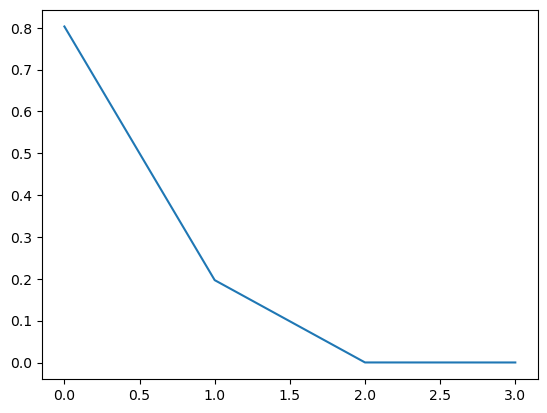

In [262]:
plt.plot(range(len(ipca.explained_variance_)),ipca.explained_variance_ratio_)

Notamos que tanto pca como ipca tienen buen score, dado que la variable que intentamos predicir tiene comportamiento lineal con otras. por el contrario el kernel para datos no lineales no es optimo para este modelo.

Usaremos Ipca dado que el set de datos es pequeño y tienen un buen desempeño.

# Ensambladores :

Baggin

In [263]:
modelos = (
LogisticRegression(solver = "lbfgs", max_iter = 1000), 
DecisionTreeClassifier(),
KNeighborsClassifier(),
RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=123),
LinearSVC(),
SVC(),
SGDClassifier())

def estimadores_bagginIPCA(clasificadores):
    for clasificador in clasificadores:
        modelo = BaggingClassifier(
            base_estimator= clasificador , n_estimators= 30).fit(
            Xipca_train,y_train_balanced)
        modelo_predict = modelo.predict(Xipca_test)
        print(f"""
        Clasificador: " {clasificador} 
        N_estamaciones: " {modelo.n_estimators}
        Presición_Predicción : {accuracy_score(modelo_predict , y_test)}
        ------------------------------------------------ """)

estimadores_bagginIPCA(modelos)


        Clasificador: " LogisticRegression(max_iter=1000) 
        N_estamaciones: " 30
        Presición_Predicción : 0.893048128342246
        ------------------------------------------------ 

        Clasificador: " DecisionTreeClassifier() 
        N_estamaciones: " 30
        Presición_Predicción : 0.8863636363636364
        ------------------------------------------------ 

        Clasificador: " KNeighborsClassifier() 
        N_estamaciones: " 30
        Presición_Predicción : 0.6443850267379679
        ------------------------------------------------ 

        Clasificador: " RandomForestClassifier(max_depth=10, n_estimators=123) 
        N_estamaciones: " 30
        Presición_Predicción : 0.893048128342246
        ------------------------------------------------ 

        Clasificador: " LinearSVC() 
        N_estamaciones: " 30
        Presición_Predicción : 0.8542780748663101
        ------------------------------------------------ 

        Clasificador: " SVC() 
      

Boostin

In [264]:
boost = GradientBoostingClassifier(n_estimators=120  , learning_rate=.1 , subsample=1).fit(Xipca_train, y_train_balanced)
boost_pred = boost.predict(Xipca_test)
print("="*64)
print(accuracy_score(boost_pred, y_test))

0.8957219251336899


# Optimización Parametrica

In [265]:
clasificador = RandomForestClassifier()
parametros = {
    'n_estimators': range(90, 130),
    'criterion': [ "gini" , "entropy", "log_loss"],
    'max_depth': range(6 , 11)}

estimacionParametrica = RandomizedSearchCV(
    clasificador, parametros, n_iter=15, cv=6).fit(Xipca_train, y_train_balanced)

print(estimacionParametrica.best_estimator_)
print(estimacionParametrica.best_params_)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=93)
{'n_estimators': 93, 'max_depth': 10, 'criterion': 'entropy'}


 Presición_Predicción : 0.8957219251336899 


<Figure size 1100x1100 with 0 Axes>

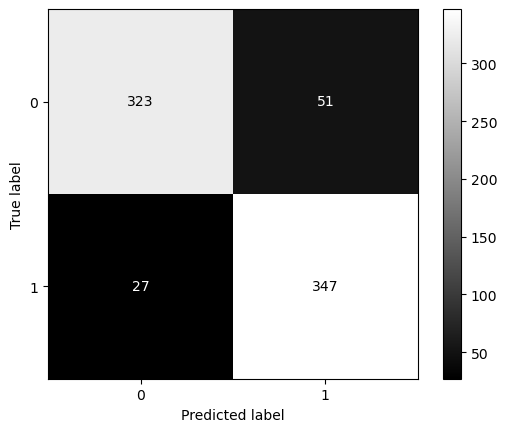

In [266]:
randomF_model= RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=107).fit(Xipca_train, y_train_balanced)
prediccionRandomForest = randomF_model.predict(Xipca_test)

#Resultados
fig = plt.figure(figsize=(11,11))
print(f""" Presición_Predicción : {accuracy_score(prediccionRandomForest, y_test)} """)
cm = confusion_matrix(y_test, prediccionRandomForest ,labels= randomF_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=randomF_model.classes_)
disp.plot(cmap='gray')
plt.show()

Score Final: __90 %__

# Exportacion de Modelo

In [267]:
#joblib.dump(randomF_model, 'randomForest_model.pkl')

Importación de modelo

In [268]:
model = joblib.load('randomForest_model.pkl')
pred = model.predict(Xipca_test)

 Presición_Predicción : 0.9077540106951871 


<Figure size 1100x1100 with 0 Axes>

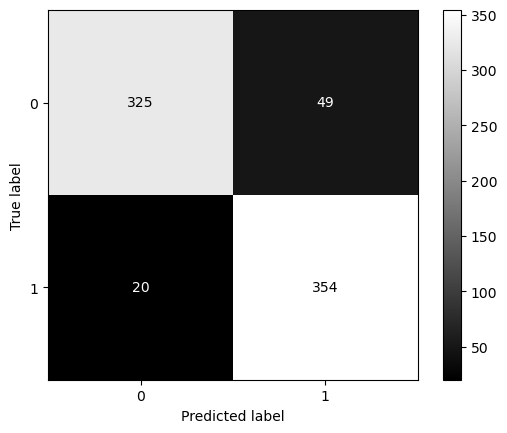

In [269]:
print(f""" Presición_Predicción : {accuracy_score(pred, y_test)} """)
fig = plt.figure(figsize=(11,11))
cm = confusion_matrix(y_test, pred ,labels= model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model.classes_).plot(cmap = "gray")
plt.show()

In [270]:
predDF = pd.DataFrame( pred) 
predDF

,0
0,1
1,1
2,0
3,0
4,1
...,...
743,0
744,0
745,0
746,1
